Tässä notebookissa tehdään Silver-tason prosessoinnit datalle, eli ladataan bronze_pipeline.ipynb ETL-putken luomat lopputulokset ja otetaan data esikäsittellyyn. Esikäsittelyssä data putsataan ja prosessoidaan haluttuun muotoon. Tämän jälkeen data tallennetaan Gold-tason tauluun, joka toimii datan lopullisena tallennuspaikkana, josta sitä käytetään tämän projektin muissa välivaiheissa.

In [2]:
!pip install duckdb

In [28]:
import duckdb
import pandas as pd
duckdb_path = "data/duckdb.database" # Duckdb tietokannalle annettava nimi, tallentuu lokaalisti
table_name = "Bronze_SensorData" # Tietokantataulu, josta luetaan

# Ota yhteys tietokantaa ja tarkista mitä dataa taulusta löytyy
conn = duckdb.connect(database=duckdb_path)
conn.table(table_name).show()
conn.close()

┌─────────┬──────────────────────────────────┬───────┬───────┬───────┬───────┐
│ node_id │            timestamp             │   x   │   y   │   z   │   q   │
│  int32  │             varchar              │ int32 │ int32 │ int32 │ int32 │
├─────────┼──────────────────────────────────┼───────┼───────┼───────┼───────┤
│   51889 │ 2019-03-07 13:04:56.080345+00:00 │     0 │     0 │     0 │   176 │
│   51889 │ 2019-03-07 13:05:09.080128+00:00 │     0 │     0 │     0 │    32 │
│   51889 │ 2019-03-07 13:05:16.079998+00:00 │     0 │     0 │     0 │   202 │
│   51889 │ 2019-03-07 13:05:17.078234+00:00 │     0 │     0 │     0 │   229 │
│   51889 │ 2019-03-07 13:05:19.077941+00:00 │     0 │     0 │     0 │    64 │
│   51889 │ 2019-03-07 13:05:20.07851+00:00  │     0 │     0 │     0 │   184 │
│   51889 │ 2019-03-07 13:05:21.078149+00:00 │     0 │     0 │     0 │   103 │
│   51889 │ 2019-03-07 13:05:23.078481+00:00 │     0 │     0 │     0 │    92 │
│   51889 │ 2019-03-07 13:05:24.078174+00:00 │     0

In [29]:
import duckdb
import pandas as pd
duckdb_path = "data/duckdb.database" # Duckdb tietokannalle annettava nimi, tallentuu lokaalisti
table_name = "Bronze_SensorData" # Tietokantataulu, josta luetaan

# Ota yhteys tietokantaa ja tarkista mitä dataa taulusta löytyy
conn = duckdb.connect(database=duckdb_path)
df = conn.sql(f"SELECT * FROM {table_name} WHERE node_id = 3200").df() # Tallenentaan taulun data Pandasin dataframeen
conn.close()

In [4]:
df.info(verbose=True)
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6489294 entries, 0 to 6489293
Data columns (total 6 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   node_id    int32 
 1   timestamp  object
 2   x          int32 
 3   y          int32 
 4   z          int32 
 5   q          int32 
dtypes: int32(5), object(1)
memory usage: 173.3+ MB


,node_id,timestamp,x,y,z,q
0,3200,2019-03-07 11:46:19.078016+00:00,0,0,0,51
1,3200,2019-03-07 11:46:20.078012+00:00,0,0,0,163
2,3200,2019-03-07 11:46:21.078081+00:00,0,0,0,42
3,3200,2019-03-07 11:46:22.07813+00:00,0,0,0,105
4,3200,2019-03-13 15:29:43.686639+00:00,-50,50,0,106
...,...,...,...,...,...,...
6489289,3200,2020-01-22 17:53:32.478699+00:00,253,1143,0,98
6489290,3200,2020-01-22 17:53:35.478839+00:00,256,1152,0,123
6489291,3200,2020-01-22 17:53:36.478961+00:00,501,2034,0,108
6489292,3200,2020-01-22 17:53:46.479005+00:00,745,2914,0,113


In [3]:
# Tehdään perus EDA (Explorative Data Analysis)
!pip install ydata-profiling
!pip install setuptools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.9/357.9 kB 10.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 19.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.9/394.9 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 16.8 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=bcb2b21b928dd942959b97e86ecf4b58f8ec615ca5b446023a87b129259dfc6f
  Stored in directory: /home/jovyan/.cache/pip/wheels/8d/5

In [30]:
# Tässä prosessoinnin vaiheessa poistetaan Z & Q sarakkeet

df = df.drop(columns=['z', 'q'])
print(df.describe())
df.info(verbose=True)

         node_id             x             y
count  6489294.0  6.489294e+06  6.489294e+06
mean      3200.0  7.801438e+02  2.594087e+03
std          0.0  1.977287e+03  7.415937e+02
min       3200.0 -3.281800e+04 -3.270500e+04
25%       3200.0  4.600000e+01  2.453000e+03
50%       3200.0  1.320000e+02  2.536000e+03
75%       3200.0  3.130000e+02  2.642000e+03
max       3200.0  3.265500e+04  3.270600e+04
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6489294 entries, 0 to 6489293
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   node_id    int32 
 1   timestamp  object
 2   x          int32 
 3   y          int32 
dtypes: int32(3), object(1)
memory usage: 123.8+ MB


In [31]:
# Tässä prosessoinnin vaiheessa laitetaan oikea tietotyyppi timestamp sarakkeelle (datetime)

df["timestamp"] = pd.to_datetime(df["timestamp"])

df.info(verbose=True)
print(df.head(n=10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6489294 entries, 0 to 6489293
Data columns (total 4 columns):
 #   Column     Dtype              
---  ------     -----              
 0   node_id    int32              
 1   timestamp  datetime64[ns, UTC]
 2   x          int32              
 3   y          int32              
dtypes: datetime64[ns, UTC](1), int32(3)
memory usage: 123.8 MB
   node_id                        timestamp   x   y
0     3200 2019-03-07 11:46:19.078016+00:00   0   0
1     3200 2019-03-07 11:46:20.078012+00:00   0   0
2     3200 2019-03-07 11:46:21.078081+00:00   0   0
3     3200 2019-03-07 11:46:22.078130+00:00   0   0
4     3200 2019-03-13 15:29:43.686639+00:00 -50  50
5     3200 2019-03-13 15:29:44.686592+00:00 -50  50
6     3200 2019-03-13 15:29:45.686654+00:00 -50  50
7     3200 2019-03-13 15:29:46.686785+00:00 -50  50
8     3200 2019-03-13 15:29:47.687715+00:00 -50  50
9     3200 2019-03-13 15:29:48.686671+00:00 -50  50


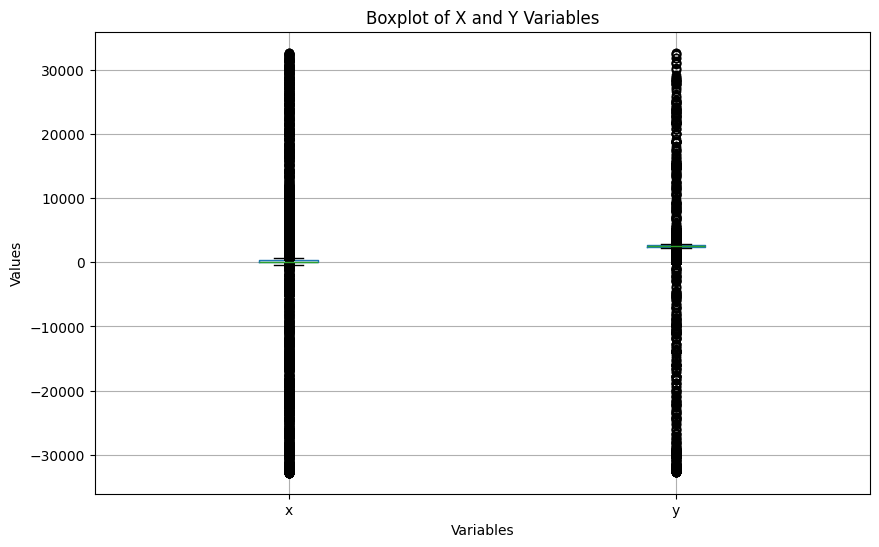

         node_id             x             y          z             q
count  6489294.0  6.489294e+06  6.489294e+06  6489294.0  6.489294e+06
mean      3200.0  7.801438e+02  2.594087e+03        0.0  6.484833e+01
std          0.0  1.977287e+03  7.415937e+02        0.0  3.327497e+01
min       3200.0 -3.281800e+04 -3.270500e+04        0.0  0.000000e+00
25%       3200.0  4.600000e+01  2.453000e+03        0.0  4.800000e+01
50%       3200.0  1.320000e+02  2.536000e+03        0.0  5.600000e+01
75%       3200.0  3.130000e+02  2.642000e+03        0.0  6.900000e+01
max       3200.0  3.265500e+04  3.270600e+04        0.0  2.550000e+02


In [46]:
# Tarkastellaan ja poistetaan Outlierit
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 6))
df.boxplot(column=['x', 'y'])
plt.title('Boxplot of X and Y Variables')
plt.ylabel('Values')
plt.xlabel('Variables')
plt.show()

print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 1088631 entries, 0 to 6489290
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype              
---  ------     --------------    -----              
 0   node_id    1088631 non-null  int32              
 1   timestamp  1088631 non-null  datetime64[ns, UTC]
 2   x          1088631 non-null  int32              
 3   y          1088631 non-null  int32              
dtypes: datetime64[ns, UTC](1), int32(3)
memory usage: 29.1 MB


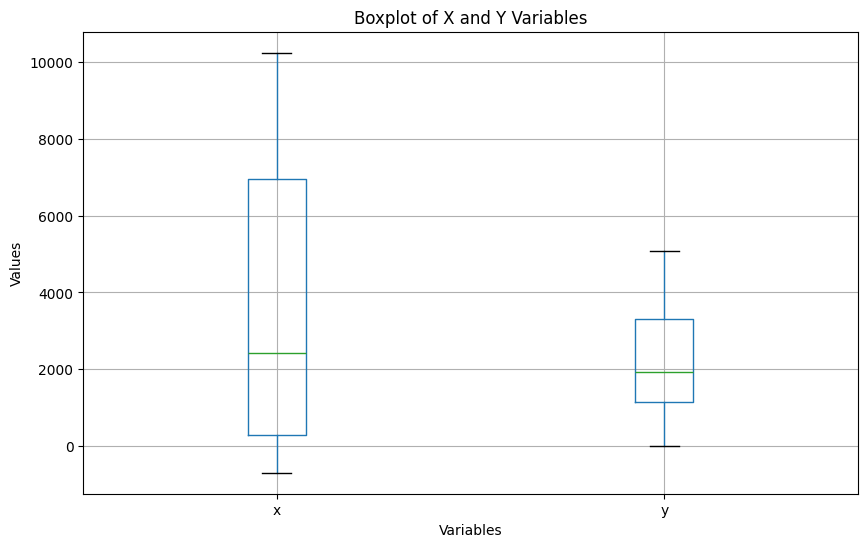

In [32]:
# Tarkastellaan ja poistetaan Outlierit

# Määritellään ylä ja alarajat X-akselissa 
lower_bound_X = -700
upper_bound_X = 10250


# Määritellään ylä ja alarajat y-akselissa
lower_bound_Y = 0
upper_bound_Y = 5100

# Filteröidään pois
outliers_X = df[(df['x'] < lower_bound_X) | (df['x'] > upper_bound_X)]
outliers_Y = df[(df['y'] < lower_bound_Y) | (df['y'] > upper_bound_Y)]

#Latausasemien filtteröinti
charging_station1 = df[df['x'].between(-150, 1600) & (df['y'] > 2900)]
charging_station2 = df[(df['y']> 2000) & df['x'].between(-150, 800)]


# Poistetaan outlierit
df = df[~df.index.isin(outliers_X.index) & ~df.index.isin(outliers_Y.index)]
df = df[~df.index.isin(charging_station1.index) & ~df.index.isin(charging_station2.index)]

df.info(verbose=True)





import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 6))
df.boxplot(column=['x', 'y'])
plt.title('Boxplot of X and Y Variables')
plt.ylabel('Values')
plt.xlabel('Variables')
plt.show()

### Onko jotain muuta?

- Poistetaan järjestelmän koordinaatiston vanhat rajoitteet. Ainakin aikaisemmassa versiossa x,y akselit olivat rajoitettu tiettyyn arvoon, esim x>=(-50), jos kärryt menivät yli rajojen. Tällöin jos kärry meni alle -50 arvoon, niin se tallennettiin x=-50

In [33]:
limited_left_val = df['x'].isin([-50])
limited_upper_val = df['y'].isin([150])
limited_lower_val = df['y'].isin([5050])

print("Löydetty:", limited_lower_val.value_counts()[True], limited_left_val.value_counts()[True], limited_upper_val.value_counts()[True], "kpl")

df = df[~limited_left_val & ~limited_upper_val & ~limited_lower_val]

Löydetty: 9448 37049 9919 kpl


In [9]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1081371 entries, 0 to 6489293
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype              
---  ------     --------------    -----              
 0   node_id    1081371 non-null  int32              
 1   timestamp  1081371 non-null  datetime64[ns, UTC]
 2   x          1081371 non-null  int32              
 3   y          1081371 non-null  int32              
dtypes: datetime64[ns, UTC](1), int32(3)
memory usage: 28.9 MB


In [34]:
from functions.database import create_db_table
from functions.database import insert_dataframe_into_table
from functions.database import drop_table

#from functions.database import drop_table
# Tallennetaan dataframe silver tauluun

table_name = "Silver_SensorData" # tai Silver_SensorData
duckdb_path = "data/duckdb.database"
schema = f'''
        CREATE TABLE {table_name} (
        node_id INTEGER NOT NULL,
        timestamp TIMESTAMP,
        x INTEGER NOT NULL,
        y INTEGER NOT NULL,
        )
        '''

drop_table(table_name, duckdb_path) # Poista kommentti, jos tarvitsee poistaa tietokantataulu
create_db_table(database=duckdb_path, table_name=table_name,schema=schema) # Luodaan tietokantataulu
insert_dataframe_into_table(database=duckdb_path, table_name=table_name, df=df, insert=True) # Lisätään dataframe tietokantatauluun (Insert, eli lisätään rivejä vanhan perään)



Table dropped
Silver_SensorData luotu
Tallennetaan dataframe tietokantaan, jonka muoto on: (1040755, 4)
Tallennus tauluun Silver_SensorData onnistui


In [35]:
# Tarkistetaan, miltä luotu taulu näyttää:
table_name = "Silver_SensorData"
duckdb_path = "data/duckdb.database"
import duckdb
conn = duckdb.connect(database=duckdb_path)
conn.table(table_name).show()
conn.close()

┌─────────┬────────────────────────────┬───────┬───────┐
│ node_id │         timestamp          │   x   │   y   │
│  int32  │         timestamp          │ int32 │ int32 │
├─────────┼────────────────────────────┼───────┼───────┤
│    3200 │ 2019-03-07 13:46:19.078016 │     0 │     0 │
│    3200 │ 2019-03-07 13:46:20.078012 │     0 │     0 │
│    3200 │ 2019-03-07 13:46:21.078081 │     0 │     0 │
│    3200 │ 2019-03-07 13:46:22.07813  │     0 │     0 │
│    3200 │ 2019-03-14 11:57:31.687637 │   228 │  1084 │
│    3200 │ 2019-03-14 11:57:32.687573 │   272 │  1240 │
│    3200 │ 2019-03-14 11:57:33.687582 │   314 │  1388 │
│    3200 │ 2019-03-14 11:57:34.687527 │   352 │  1523 │
│    3200 │ 2019-03-14 11:57:35.687944 │   386 │  1642 │
│    3200 │ 2019-03-14 11:57:36.688477 │   415 │  1745 │
│      ·  │             ·              │    ·  │    ·  │
│      ·  │             ·              │    ·  │    ·  │
│      ·  │             ·              │    ·  │    ·  │
│    3200 │ 2019-03-15 16:16:13